In this notebook, we will compare our two models using:

- Aggregate metrics
- Performance visualizations
- Dataset visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append("..")

from ml_editor.data_processing import format_raw_df

data_path = Path('../data/writers_with_features.csv')
df = pd.read_csv(data_path)

In [2]:
from sklearn.externals import joblib

clf_1 = joblib.load(Path("../models/model_1.pkl")) 
vectorizer_1 = joblib.load(Path("../models/vectorizer_1.pkl")) 
clf_2 = joblib.load(Path("../models/model_2.pkl"))
vectorizer_2 = joblib.load(Path("../models/vectorizer_2.pkl")) 

# clf_3 does not vectorize text
clf_3 = joblib.load(Path("../models/model_3.pkl")) 

In [3]:
from ml_editor.data_processing import get_split_by_author

train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [4]:
from ml_editor.data_processing import get_vectorized_series, get_feature_vector_and_label
from ml_editor.model_v2 import POS_NAMES

train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer_1)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer_1)

features_1 = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]

features_2 = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
features_2.extend(POS_NAMES.keys())

X_test_1, y_test = get_feature_vector_and_label(test_df, features_1)
X_test_2, y_test = get_feature_vector_and_label(test_df, features_2)
X_test_3 = test_df[features_2].astype(float)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/emmanuel.ameisen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
clf1_predicted_proba = clf_1.predict_proba(X_test_1)
clf2_predicted_proba = clf_2.predict_proba(X_test_2)
clf3_predicted_proba = clf_3.predict_proba(X_test_3)

clf1_predicted = clf_1.predict(X_test_1)
clf2_predicted = clf_2.predict(X_test_2)
clf3_predicted = clf_3.predict(X_test_3)

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

for i, y_predicted in enumerate([clf1_predicted, clf2_predicted, clf3_predicted]):
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print("Model %s: Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % ((i+1), accuracy, precision, recall, f1))

Model 1: Validation accuracy = 0.614, precision = 0.622, recall = 0.537, f1 = 0.577
Model 2: Validation accuracy = 0.618, precision = 0.632, recall = 0.524, f1 = 0.573
Model 3: Validation accuracy = 0.584, precision = 0.597, recall = 0.461, f1 = 0.520


In [32]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def get_multiple_calibration_plot(predicted_proba_arrays, true_y, figsize=(10, 8)):
    """
    Inspired by sklearn example
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    :param figsize: size of the output figure
    :param predicted_proba_y: the predicted probabilities of our model for each example
    :param true_y: the true value of the label
    :return: calibration plot
    """

    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     print("\tBrier: %1.3f" % clf_score)
    
    for i,predicted_proba_y in enumerate(predicted_proba_arrays):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_y, predicted_proba_y, n_bins=10
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label = "Model %s" % (i + 1)
        )

        ax2.hist(
            predicted_proba_y,
            range=(0, 1),
            bins=10,
            histtype="step",
            label = "Model %s" % (i + 1),
            lw=2,
        )

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc="lower right")
    ax1.set_title("Calibration plot")

    ax2.set_title("Probability distribution")
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol=2)

    plt.tight_layout()

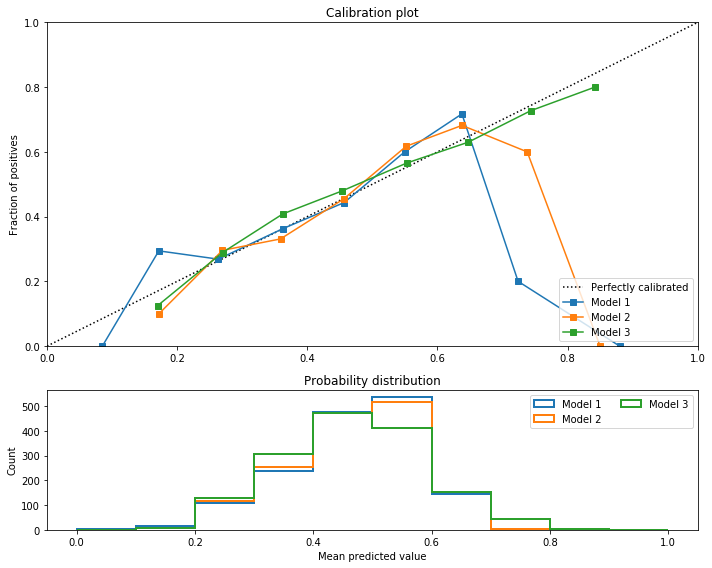

In [33]:
predictions = [clf1_predicted[:,1], clf2_predicted[:,1], clf3_predicted[:,1]]

get_multiple_calibration_plot(predictions, y_test)

No handles with labels found to put in legend.


	Brier: 0.236


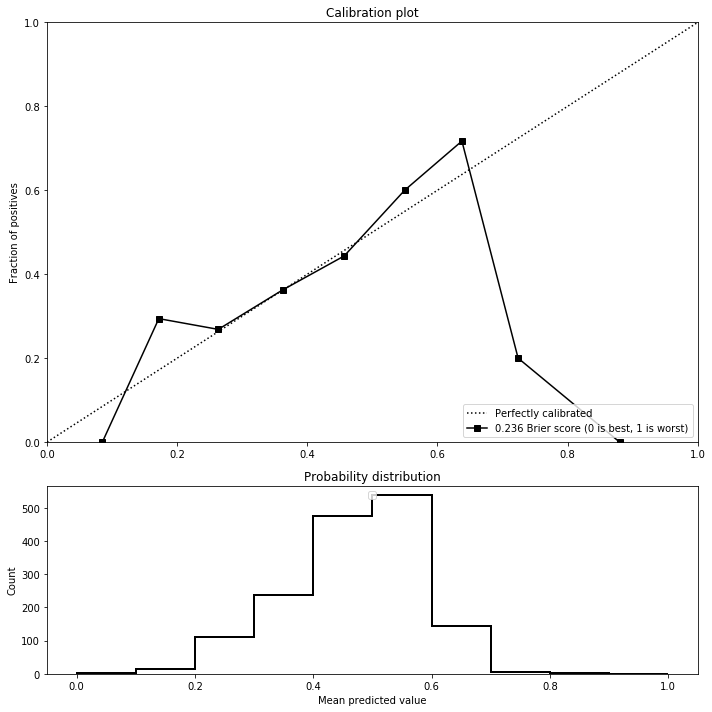

In [6]:
from ml_editor.model_evaluation import get_calibration_plot

get_calibration_plot(clf1_predicted[:,1], y_test)

No handles with labels found to put in legend.


	Brier: 0.234


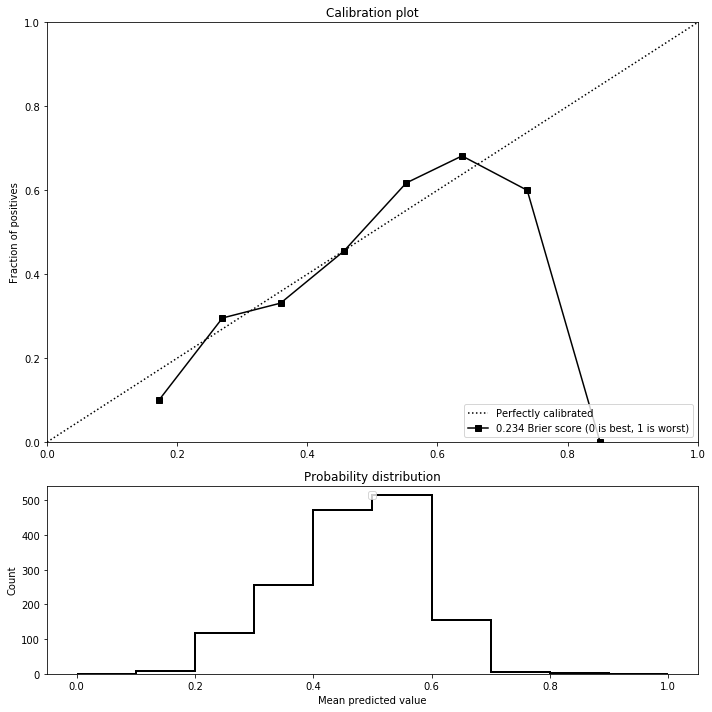

In [7]:
get_calibration_plot(clf2_predicted[:,1], y_test)

No handles with labels found to put in legend.


	Brier: 0.238


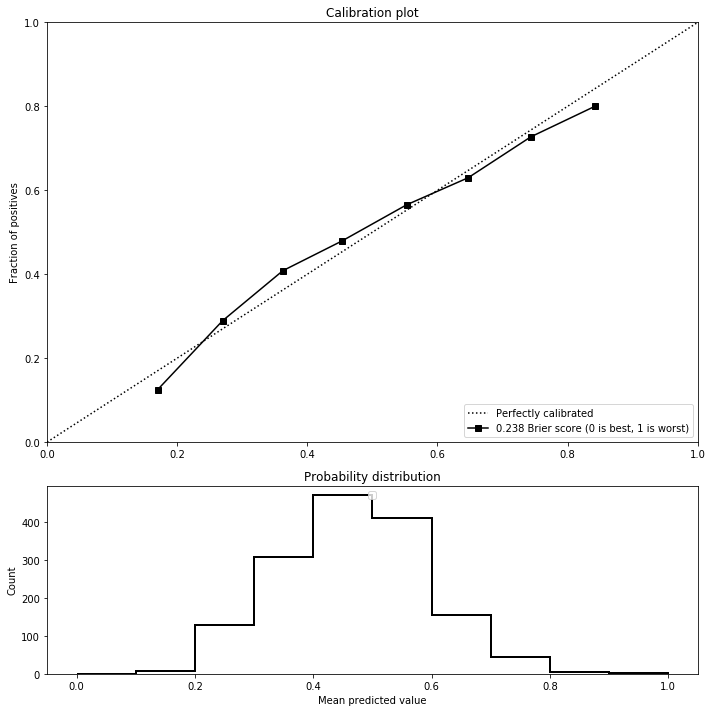

In [8]:
get_calibration_plot(clf3_predicted[:,1], y_test)